# Import Library and Models

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model import ResNet, BasicBlock

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import torchvision

# library for viaulize and summary
from torchsummary import summary
from torchview import draw_graph

# Device check and define model structure

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock, [3, 3, 3]).to(device) #n=3 for ResNet20
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,


(dot.exe:48224): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


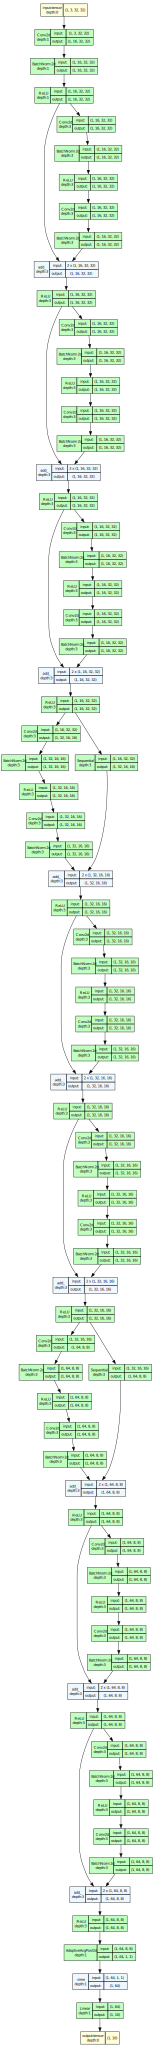

In [3]:
# Visualize model with torchviz
# https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch 

model_graph = draw_graph(model, (torch.zeros(1, 3, 32, 32).to(device)))
model_graph.visual_graph

# Data augmentation for training

In [4]:
# We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
# and a 32×32 crop is randomly sampled from the padded image or its horizontal flip. 

transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # per-pixel mean substraction
])

In [5]:
# For testing, we only evaluate
# the single view of the original 32×32 image.
# Define the transformations for the training and test sets

# Load the training and test datasets
train_dataset = datasets.CIFAR10(root='../../data/cifar10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../../data/cifar10', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create data loaders
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Show random sampled image from training dataset

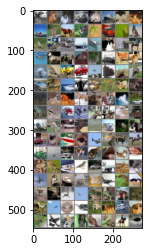

In [7]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

# Define criterion, optimizer and scheduler

In [8]:
# We use a weight decay of 0.0001 and momentum of 0.9,
# and adopt the weight initialization in [13] and BN [16] but with no dropout.
# These models are trained with a minibatch size of 128 on two GPUs. 
# We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations,
# and terminate training at 64k iterations, which is determined on a 45k/5k train/val split. 

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)

total_iteration = 0

In [9]:
# Training loop
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # print statistics for each epoch
    # calculate validation loss from valid loader
    with torch.no_grad():
        val_input, val_target = next(iter(valid_loader))
        val_input, val_target = val_input.to(device), val_target.to(device)
        val_output = model(val_input)
        val_loss = criterion(val_output, val_target)
    print('[%d] train loss: %.3f valid loss: %.3f' %
            (epoch, running_loss / i, val_loss))
    running_loss = 0.0

print('Finished Training')

[0] train loss: 1.565 valid loss: 1.279
[1] train loss: 1.078 valid loss: 1.048
[2] train loss: 0.875 valid loss: 0.691
[3] train loss: 0.761 valid loss: 1.014
[4] train loss: 0.685 valid loss: 0.629
[5] train loss: 0.625 valid loss: 0.737
[6] train loss: 0.586 valid loss: 0.480
[7] train loss: 0.543 valid loss: 0.672
[8] train loss: 0.522 valid loss: 0.593
[9] train loss: 0.499 valid loss: 0.584
[10] train loss: 0.478 valid loss: 0.386
[11] train loss: 0.457 valid loss: 0.559
[12] train loss: 0.442 valid loss: 0.479
[13] train loss: 0.424 valid loss: 0.475
[14] train loss: 0.423 valid loss: 0.576
[15] train loss: 0.412 valid loss: 0.541
[16] train loss: 0.398 valid loss: 0.464
[17] train loss: 0.385 valid loss: 0.464
[18] train loss: 0.382 valid loss: 0.468
[19] train loss: 0.370 valid loss: 0.391
[20] train loss: 0.360 valid loss: 0.364
[21] train loss: 0.361 valid loss: 0.572
[22] train loss: 0.354 valid loss: 0.308
[23] train loss: 0.345 valid loss: 0.474
[24] train loss: 0.337 val

# Result

In [14]:
# Test model with randomly sampled test data

def get_test_result(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Correct: {} Total: {} Accuracy: {}".format(correct, total, correct/total))

get_test_result(model, test_loader)

Correct: 9010 Total: 10000 Accuracy: 0.901


In [ ]:
# More training with different learning rate

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)

# Training loop
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # print statistics for each epoch
    # calculate validation loss from valid loader
    with torch.no_grad():
        val_input, val_target = next(iter(valid_loader))
        val_input, val_target = val_input.to(device), val_target.to(device)
        val_output = model(val_input)
        val_loss = criterion(val_output, val_target)
    print('[%d] train loss: %.3f valid loss: %.3f' %
            (epoch, running_loss / i, val_loss))
    running_loss = 0.0

print('Finished Training')

[0] train loss: 0.160 valid loss: 0.350
[1] train loss: 0.159 valid loss: 0.291
[2] train loss: 0.156 valid loss: 0.322
[3] train loss: 0.159 valid loss: 0.300
[4] train loss: 0.159 valid loss: 0.384
[5] train loss: 0.158 valid loss: 0.291
[6] train loss: 0.158 valid loss: 0.267
[7] train loss: 0.156 valid loss: 0.429
[8] train loss: 0.156 valid loss: 0.322
[9] train loss: 0.153 valid loss: 0.465
[10] train loss: 0.156 valid loss: 0.335
[11] train loss: 0.153 valid loss: 0.327
[12] train loss: 0.154 valid loss: 0.349
[13] train loss: 0.156 valid loss: 0.384
[14] train loss: 0.156 valid loss: 0.263
[15] train loss: 0.153 valid loss: 0.276
[16] train loss: 0.152 valid loss: 0.388
[17] train loss: 0.154 valid loss: 0.356
[18] train loss: 0.151 valid loss: 0.295
[19] train loss: 0.153 valid loss: 0.374
[20] train loss: 0.152 valid loss: 0.387
[21] train loss: 0.151 valid loss: 0.265
[22] train loss: 0.152 valid loss: 0.277
[23] train loss: 0.151 valid loss: 0.396
[24] train loss: 0.151 val

In [16]:
get_test_result(model, test_loader)

Correct: 9045 Total: 10000 Accuracy: 0.9045
